In [1]:
import meanreversion as mr
import numpy as np
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed

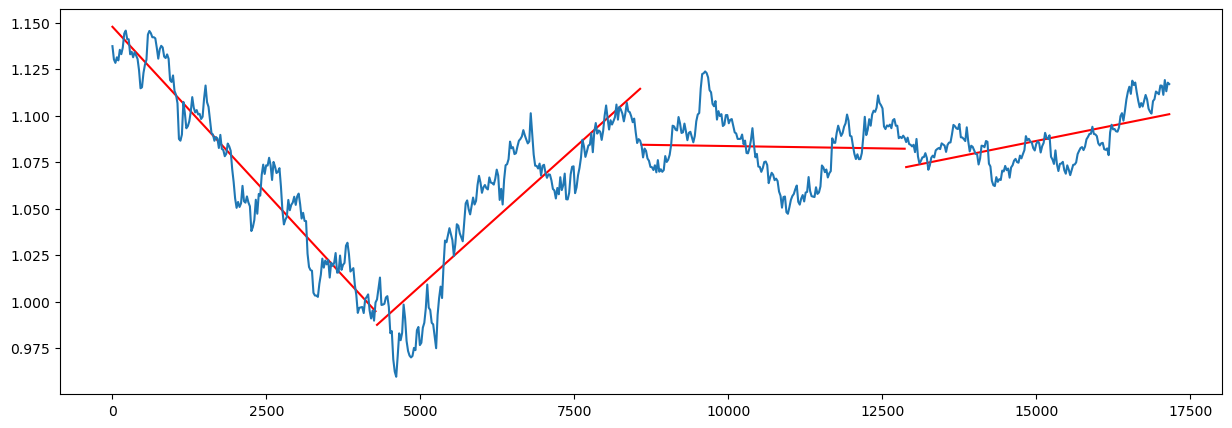

In [183]:
data = mr.download_asset("EURUSD=X", start='2022-01-01',end='2024-10-01')
mesh = np.linspace(0, len(data), 5)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot()
slices = mr.removeTrend(data, mesh, ax)
ax.plot(data.index, data["Close"])
plt.show()

Periods:  1.044943820224719
Amplitudes:  0.32160089073674886


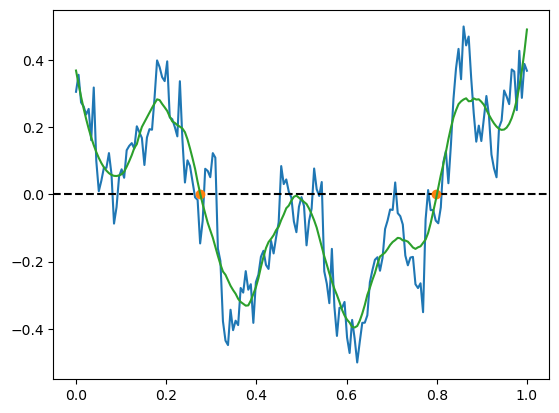

In [563]:
# TODO: extrapolate functions to meanreversion.py

x = slices[3].to_numpy()
t = slices[3].index.to_numpy()

t = (t - t.min()) / (t.max()-t.min())   # Normalize time values to [0, 1]
x = x / (x.max()-x.min())   # Normalize price values to [0, 1]

from scipy.signal import savgol_filter, find_peaks
x_filtered = savgol_filter(x, window_length=len(x)//5, polyorder=3)

def find_zeros(t : np.array, x : np.array) -> np.array:
    """
    Find the zeros of a function based on its sampled values.
    This function takes two numpy arrays, `t` and `x`, where `t` represents the
    time or independent variable and `x` represents the dependent variable. It
    returns the values of `t` where `x` crosses zero.
    
    Parameters:
     - t (np.array): An array of time or independent variable values.
     - x (np.array): An array of dependent variable values corresponding to `t`.

    Returns:
     - (np.array) An array of `t` values where `x` crosses zero.
    """
    assert len(t) == len(x), "t and x must have the same length"
    zeros = []
    for i in range(len(x)-1):
        if x[i]*x[i+1] < 0:
            zeros.append(t[i])
    return np.array(zeros, dtype=float)

def find_periods(t : np.array, x : np.array) -> np.array:
    """
    Calculate the periods between zero crossings in the given data.

    Parameters:
     - t (np.array): Array of time values.
     - x (np.array): Array of corresponding data values.

    Returns:
     - np.array: Array of periods between zero crossings, each period is calculated as twice the difference between consecutive zero crossings.
    """
    zeros = find_zeros(t, x)
    periods = []
    for i in range(len(zeros)-1):
        periods.append((zeros[i+1] - zeros[i])*2)
    periods = np.array(periods, dtype=float)
    return periods


def find_amplitudes(t : np.array, x : np.array, factor = 0.3) -> np.array:
    """
    Find the amplitudes of the peaks in the given time series data.

    Parameters:
     - t (np.array): Array of time values.
     - x (np.array): Array of corresponding data values.
     - factor (float, optional): Factor to adjust the tollerance distance between peaks. Default is 0.3.

    Returns:
     - np.array: Array of amplitudes of the detected peaks.
    """
    dist = factor*len(x)*np.mean(find_periods(t, x))/(t.max()-t.min())
    max_peaks, _ = find_peaks(x, distance=dist, height=0.0)
    min_peaks, _ = find_peaks(-x, distance=dist, height=0.0)
    return np.concatenate((x[max_peaks], -x[min_peaks]))


periods = find_periods(t, x_filtered)
peaks = find_amplitudes(t, x_filtered)

print("Periods: ", np.mean(periods))
print("Amplitudes: ", np.mean(peaks))

plt.plot(t, x)
plt.axhline(0, color='black', linestyle='--')
plt.plot(find_zeros(t, x_filtered), np.zeros(len(find_zeros(t, x_filtered))), 'o')
plt.plot(t, x_filtered)
plt.show()

In [564]:
from scipy.fftpack import fft, fftfreq, ifft

def find_period_fft(t : np.array, x : np.array) -> tuple:
    """
    Calculate the period and phase of a signal using Fast Fourier Transform (FFT).

    Parameters:
     - t (np.array): Array of time values.
     - x (np.array): Array of signal values corresponding to the time values.

    Returns:
     - tuple: A tuple containing the period of the signal (1/max_freq) and the phase of the signal.
    """
    fourier = np.abs(fft(x))
    freqs = fftfreq(len(t), t[1] - t[0])
    mask = np.where(freqs > 0)
    fourier = fourier[mask]
    freqs = freqs[mask]
    max_freq = freqs[np.argmax(fourier)]
    phase = np.angle(fft(x)[np.argmax(fourier)])
    return (1/max_freq, phase)

period_fft, phase_fft = find_period_fft(t, x_filtered)
print("Period via FFT: ", period_fft)
print("Phase via FFT: ", phase_fft)

Period via FFT:  1.0056179775280898
Phase via FFT:  -3.141592653589793


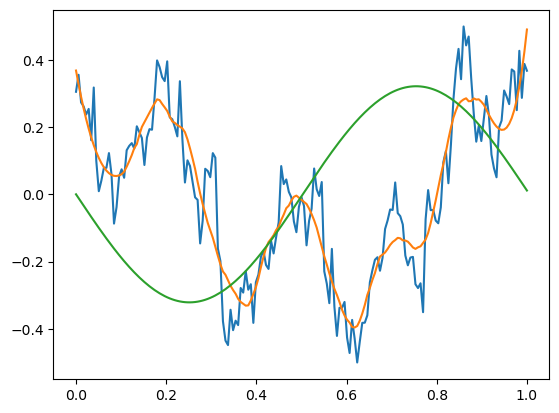

In [565]:
plt.plot(t, x)
plt.plot(t, x_filtered)
plt.plot(t, peaks.mean()*np.sin(2*np.pi*t/period_fft + phase_fft))
plt.show()

## Maximum Likelihood estimation to find volatility
As probability, we aproximate the propagator with a gaussian (we should solve the Fokker-Planck equation)

$$dx(t)=f(x,t,\boldsymbol{\theta})dt+g(x,t,\boldsymbol{\theta})dB(t)$$

$$p_{\boldsymbol{\theta}}(x,t|y)\simeq\mathcal{N}_y(x+f(x,t,\boldsymbol{\theta})t, tg^2(x,t,\boldsymbol{\theta}))$$

$$\mathcal{L}(x,t,\boldsymbol{\theta})=\prod p_{\boldsymbol{\theta}}(x,t|y)$$

$$\boldsymbol{\theta}=\arg\max_{\boldsymbol{\theta}}\mathcal{L}(x,t,\boldsymbol{\theta})$$
As minimization in quite unstable, we use the previously founded phase $\varphi$, amplitude $A$ and frequency $\omega=2\pi/T$ as exact values. We use the Ornstein Uhlenbeck process as SDE and the following functions as model:
$$f(x,t,\boldsymbol{\theta})=\theta(A\sin(\omega t+\varphi)-x)$$
$$f(x,t,\boldsymbol{\theta})=\sigma$$
The parameters to be estimated are only $\boldsymbol{\theta}=\{\theta, \sigma\}$ where $\theta$ give the Ornstein Uhlenbeck "speed" and $\sigma$ give information about volatility of the price. As mean reversion metric we can choose the ratio between amplitude and volatility: if the amplitude of the oscillation is bigger than the random fluctuation, then we have a mean reversion dynamic.
$$MRI=\frac{A}{\sigma}$$
if $MRI$ (Mean Reversion Index) is significally bigger than one, then is more likely that we have mean reversion.

In [631]:
def propagator(x : float, y : float, t : float, f : callable, g : callable, theta : list)  -> float:
    """
    Computes the propagator function for a given set of parameters. It uses a gaussian distribution to approximate the transition probability.

    Parameters:
     - x (float): Initial value.
     - y (float): Final value.
     - t (float): Time parameter.
     - f (function): Function that takes t, x, and theta as arguments and returns a float.
     - g (function): Function that takes x and theta as arguments and returns a float.
     - theta (list): List of parameters for the functions f and g.

    Returns:
     - float: The value of the propagator function.
    """
    return np.exp(-(y-x-f(t,x,theta)*t)**2/(2*t*g(x,theta)**2 + 1e-10)) / np.sqrt(2*np.pi*t*g(x,theta)**2 + 1e-10)

def log_likelihood(theta : list, X : np.array, t : np.array, f : callable, g : callable) -> float:
    """
    Calculate the negative log-likelihood for a given set of parameters.

    Parameters:
     - theta (array-like): The parameters to be estimated.
     - X (array-like): The observed data points.
     - t (array-like): The time points corresponding to the observed data.
     - f (function): The drift function of the model.
     - g (function): The diffusion function of the model.

    Returns:
     - float: The negative log-likelihood value.
    """
    N = len(X)
    logL = 0
    for i in range(1, N):
        p = propagator(X[i-1], X[i], t[i]-t[i-1], f, g, theta) + 1e-10
        if p <= 0:
            return np.inf
        logL += np.log(p) + 1e-6 * np.sum(np.array(theta)**2)
    return -logL


# given parameters
amplitude = np.mean(peaks)
period = (np.mean(periods) + period_fft)/2
print("Amplitude: ", amplitude)
print("Period: ", period)

# definition of the SDE
def f(t, x, theta):
    return theta[1]*(amplitude*(np.sin(t*2*np.pi/period+ theta[0]) + 2*np.pi * np.cos(t*2*np.pi/period+ theta[0])/(theta[1]*period)) - x)
def g(x, theta):
    return theta[2]


from scipy.optimize import minimize

bnds = ((-2*np.pi, +2*np.pi), (0, None), (0.0, None))  # bounds for the parameters
params = [phase_fft, 1.0, 1.0]  # initial guess for the parameters ensuring positivity
print("\nInitial guess: ", params)

res = minimize(log_likelihood, params, args=(x_filtered, t, f, g), method='L-BFGS-B', options={'disp': False, 'ftol': 1e-9})
optimal_params = res.get('x')

print("Optimal parameters: ", optimal_params)
print(f"\nVolatility: {optimal_params[2]:.4}")
print(f"Amplitude-volatility ratio: {amplitude/optimal_params[2]:.4}")
print(f"Ornstein-Uhlenbeckrn half-life {np.log(2)/optimal_params[1]:.4}")

Amplitude:  0.32160089073674886
Period:  1.0252808988764044

Initial guess:  [-3.141592653589793, 1.0, 1.0]
Optimal parameters:  [-4.8640227  -0.33470153  0.2739124 ]

Volatility: 0.2739
Amplitude-volatility ratio: 1.174
Ornstein-Uhlenbeckrn half-life -2.071


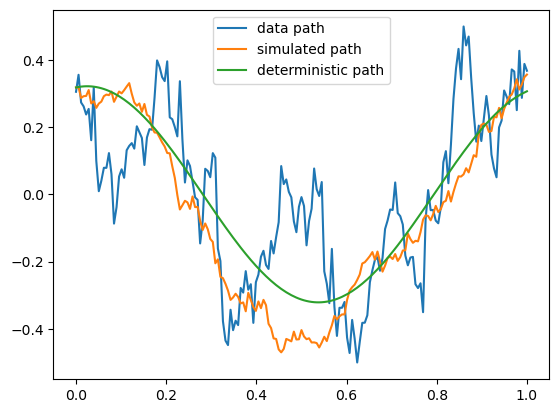

In [633]:
def SDE_solver(x0 : float, t0 : float, T : float, dt : float,  mu, sigma):
    """
    Solve the SDE dx = mu(t, x) dt + sigma(t, x) dB
    with x(t0) = x0, for t0 <= t <= T, with time step dt
    """
    N = int((T-t0)/dt)+1
    X = np.zeros(N, dtype=float)
    X[0] = x0
    for i in range(1, N):
        X[i] = X[i-1] + mu(i*dt, X[i-1]) * dt + sigma(i*dt,  X[i-1]) * np.sqrt(dt) * np.random.randn()
    return X

theta = optimal_params
mu = lambda t, x : theta[1]*(amplitude*(np.sin(t*2*np.pi/period+ theta[0]) + 2*np.pi * np.cos(t*2*np.pi/period+ theta[0])/(theta[1]*period)) - x)
sigma = lambda t, x : theta[2]

X = SDE_solver(x0=amplitude*np.sin(theta[0]), t0=0.0, T=1.0, dt=(t[1]-t[0]), mu=mu, sigma=sigma)

plt.plot(t, x, label='data path')
plt.plot(t, X, label='simulated path')
plt.plot(t, amplitude*np.sin(t*2*np.pi/period + theta[0]), label='deterministic path')
plt.legend()
plt.show()

In [ ]:
# TODO: add the MLE functions to meanreversion.py